In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
inspector = inspect(engine)
# reflect the tables
inspector.get_table_names()

['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurments = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Geting the column names for the tables
print("-Measurement Table-")
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c["name"], c["type"])

print("\n")

print("-Station Table-")
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c["name"], c["type"])

-Measurement Table-
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


-Station Table-
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurments.date).group_by('date').\
    order_by(Measurments.date.desc()).first()[0]
print(recent_date)

2017-08-23


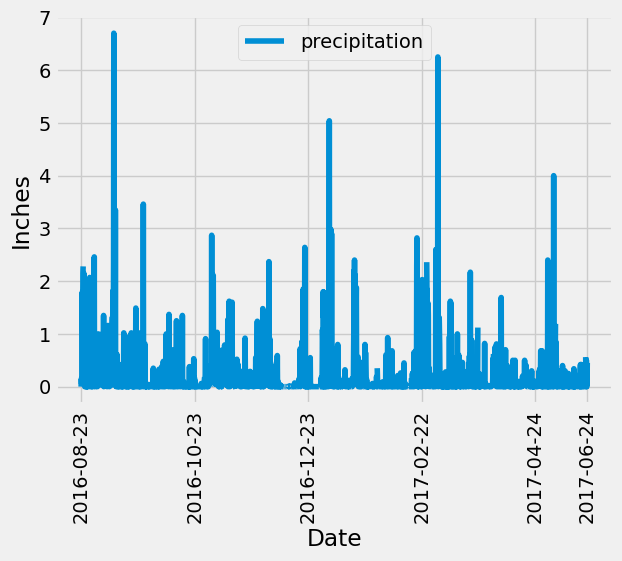

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_split = recent_date.split('-')
query_date =  dt.date(int(date_split[0]), int(date_split[1]), int(date_split[2])) - dt.timedelta(days=365)
query_date

# Perform a query to retrieve the data and precipitation scores
new = session.query(Measurments.prcp, Measurments.date).\
    filter(Measurments.date >= query_date).order_by(Measurments.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
new_df = pd.DataFrame(new, columns=["precipitation", "dates"])

# Sort the dataframe by date
new_df.sort_values(by=['dates'])

# Use Pandas Plotting with Matplotlib to plot the data
new_df.plot()

# getting every 61st unique date and setting it as x_ticks
dates = [i[1] for i in new]
unique_dates = []
for x in dates:
    if x not in unique_dates:
        unique_dates.append(x)
        
plot_dates = [unique_dates[i] for i in range(len(unique_dates)) if i%61==0]
x_ticks = [i for i in range(len(dates)) if i%500==0]
last = len(dates)-1
x_ticks.append(last)
x_ticks

plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(x_ticks, labels=plot_dates, rotation='vertical')
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
new_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.station).count()
print(station_count)

9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_data_count = session.query(func.count(Measurments.station), Measurments.station).\
    group_by(Measurments.station).order_by(func.count(Measurments.station).desc()).all()

#printing the results
for station in station_data_count:
    print(f"Station Id: {station[1]}")
    print(f"count: {station[0]}\n")


Station Id: USC00519281
count: 2772

Station Id: USC00519397
count: 2724

Station Id: USC00513117
count: 2709

Station Id: USC00519523
count: 2669

Station Id: USC00516128
count: 2612

Station Id: USC00514830
count: 2202

Station Id: USC00511918
count: 1979

Station Id: USC00517948
count: 1372

Station Id: USC00518838
count: 511



In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperatur_
most_active_station = "USC00519281"
lowest_temp = session.query(func.min(Measurments.tobs)).\
    filter(Measurments.station == most_active_station).all()[0][0]
highest_temp = session.query(func.max(Measurments.tobs)).\
    filter(Measurments.station == most_active_station).all()[0][0]
avg_temp = round(session.query(func.avg(Measurments.tobs)).\
    filter(Measurments.station == most_active_station).all()[0][0], 2)
avg_temp

# print the results
print("-Results for the most active station-")
print(f"Station Id: {most_active_station}")
print(f"highest temp: {highest_temp}")
print(f"lowest temp: {lowest_temp}")
print(f"average temp: {avg_temp}")

-Results for the most active station-
Station Id: USC00519281
highest temp: 85.0
lowest temp: 54.0
average temp: 71.66


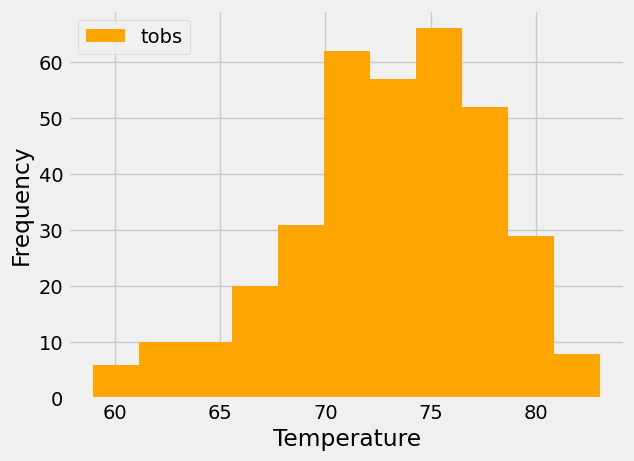

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_12_months = session.query(Measurments.tobs).filter(Measurments.date > query_date).\
    filter(Measurments.station == most_active_station).all()
data = [i[0] for i in temp_12_months]

plt.hist(data, density=False, bins=11, color="orange", label="tobs")
plt.legend(loc="upper left")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.show()


# Close Session

In [20]:
# Close Session
session.close()